In [50]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mdtraj as md
import warnings
warnings.filterwarnings("ignore")



In [2]:
pip install prody

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install python-louvain


Note: you may need to restart the kernel to use updated packages.


要计算 V_sol，您需要计算核糖核蛋白组装的溶剂可及表面积 (SASA)。 这可以使用各种算法来完成，例如滚球法或溶剂排除表面法。 获得 SASA 后，您可以使用它通过以下等式计算 V_sol：

V_sol = 1.1 * Rg^3 + 23.6

V_sol = SASA * d

In [51]:
#Filename=('AF-Q9UHJ9-F1-model_v1.pdb.gz')
Filename=('1iw7.pdb')
traj = md.load(Filename)

# Calculate Radius of gyration (Rg in unit Angstrom)
rg = round(md.compute_rg(traj)[0]*10.,6)

# give the number of residues (N, chain length)
n_resi = traj.n_residues

#Calculate area of solvent-accessible.
sasa = md.shrake_rupley(traj)

#需要将分子的总SASA乘以原子数，即乘以100，才能得到分子表面的总面积
area = round(sum(sasa[0])*100.,6) 

# calculate the average SASA value
area_per_resi = round(area/float(n_resi), 6) 


print('Rg =', rg)
print('N =', n_resi)
print('SASA =',area)
print('SASA/residue =', area_per_resi)

#这里我们可以计算出V_Sol

Rg = 107.091915
N = 12783
SASA = 363222.550393
SASA/residue = 28.4145


回旋半径和回旋张量的计算通常使用分子中所有原子的坐标信息。回旋半径表示分子的整体大小和形状，可以使用各向同性的物理量来描述；回旋张量表示分子在三个主轴方向上的惯性矩阵，可以用于描述分子的形状和内部动力学性质。

$G_{ij} = \frac{1}{M}\sum_{k=1}^M m_k(x_i^{(k)} - x_{\mathrm{com},i})(x_j^{(k)} - x_{\mathrm{com},j})$

In [52]:
import MDAnalysis as mda
import numpy as np

# Load the protein trajectory and topology
u = mda.Universe(Filename)

#一个MDAnalysis的Universe对象，包含分子的结构信息，如原子类型、化学键、残基等

u = u.select_atoms('not (name H*)')
u = u.select_atoms('not resname HOH')

# Select all protein atoms
protein = u.select_atoms('protein')

# Calculate the center of mass of the protein
c_m = protein.center_of_mass()

# Calculate the positions of the protein relative to the center of mass
positions = protein.positions - c_m

#在这里我们可以计算出V_E


# Calculate the gyration tensor
gyration_tensor = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        gyration_tensor[i,j] = np.sum(positions[:,i] * positions[:,j])

# Divide by the number of atoms to get the average
n_atoms = len(positions)
gyration_tensor /= n_atoms

# Calculate the eigenvectors and eigenvalues of the gyration tensor
eigenvalues, eigenvectors = np.linalg.eigh(gyration_tensor)


# Print the eigenvalues and eigenvectors
print('Gyration tensor eigenvalues: ', eigenvalues)
print('Gyration tensor eigenvectors: ', eigenvectors)
Lx = round(eigenvalues[0]**.5, 6)
Ly = round(eigenvalues[1]**.5, 6)
Lz = round(eigenvalues[2]**.5, 6)
print('Lengths of the semi-axes =', Lx, Ly, Lz)
u.write('output.gro')


Gyration tensor eigenvalues:  [ 511.97463858 1251.37470337 9630.78755084]
Gyration tensor eigenvectors:  [[-0.31860212  0.30652902 -0.89695744]
 [-0.23837466  0.88994836  0.38880514]
 [ 0.91742586  0.33768607 -0.21047068]]
Lengths of the semi-axes = 22.626857 35.374775 98.136576


DSSP是一种用于蛋白质二级结构分析的计算机程序。它可以将一个PDB文件中的蛋白质结构中的每个氨基酸归类到α螺旋、β折叠、转角、无规卷曲等几个主要二级结构类型中，并分析出各个二级结构类型的分布情况、长度、面积等信息，从而提供了有关蛋白质结构和功能的重要信息。DSSP程序还可以计算出二级结构之间的氢键数目和氢键的类型，提供了对蛋白质分子内部相互作用的分析。DSSP程序输出的结果可以用于蛋白质结构的可视化和分析，对于研究蛋白质结构和功能具有重要的意义

In [53]:

dssp1 = md.compute_dssp(traj, simplified=False)[0]

dssp2 = md.compute_dssp(traj, simplified=True)[0]

In [54]:
n_loop = 0
n_coil = 0

for w in dssp1:
    if w == ' ':
        n_loop += 1

for w in dssp2:
    if w == 'C':
        n_coil += 1
        
frac_loop = round(float(n_loop)/float(len(dssp1)), 6)
print('Loop fraction (based on unsimplifed DSSP): ', frac_loop)

frac_coil = round(float(n_coil)/float(len(dssp2)), 6)
print('Coil fraction (based on simplifed DSSP): ', frac_coil)

Loop fraction (based on unsimplifed DSSP):  0.126105
Coil fraction (based on simplifed DSSP):  0.259955


The loop fraction based on unsimplified DSSP can be calculated as the fraction of residues classified as "C" or "S" in the secondary structure assignment. In the unsimplified DSSP, "C" represents coil or random coil, while "S" represents bend. Therefore, the loop fraction can be calculated as:

loop_fraction = (number of residues classified as "C" or "S") / (total number of residues in the protein)

Coil fraction 是指蛋白质中由非结构化的、没有二级结构的氨基酸残基所占的比例。其计算公式为：

Coil fraction= number of residues without assigned secondary structure
total number of residues/total number of residues number of residues without assigned secondary structure
​
 

其中，"number of residues without assigned secondary structure" 表示没有被归类到 $\alpha$ 螺旋、$\beta$ 折叠、$\pi$ 螺旋等任何一种二级结构中的氨基酸残基数。

In [55]:
import community


In [56]:
# Load the necessary packages
# - Prody: elastic network model calcualtions (http://prody.csb.pitt.edu/index.html)
# - Networkx: network analysis (https://networkx.org/)
# - Community: Network partition (https://python-louvain.readthedocs.io/en/latest/index.html)


from prody import *
import networkx as nx
import community
pdb_full = parsePDB(Filename)
calphas = pdb_full.select('calpha')
N = len(calphas)

# Cutoff distance
rc = 8.

# Build Kirchhoff matrix by Prody (graph Laplacain)
gnm = GNM('GNM_'+ Filename)
gnm.buildKirchhoff(calphas, cutoff=rc)
tmpHessian = gnm.getKirchhoff()

# Build the network by NetworkX
G = nx.Graph()
for i in range(N):
    # Add nodes
    G.add_node(i)
for i in range(N):
    for j in range(i+1, N):
        if j>i and tmpHessian[i][j]<-.9:
            # Add edges
            G.add_edge(i,j)
            
# Calculate Assortativity
assort = nx.degree_assortativity_coefficient(G)

# Find the partition of the network
parti = community.best_partition(G)

# Calculate modularity
Q = community.modularity(parti, G)

print('Assortativity: ', round(assort,6))
print('Modularity: ', round(Q,6))

@> 59529 atoms and 1 coordinate set(s) were parsed in 0.54s.
@> Kirchhoff was built in 0.10s.


Assortativity:  0.388619
Modularity:  0.902685


改变截止距离会影响蛋白质或 RNA 分子的结构特征。截止距离决定了哪些原子或残基被视为邻居，因此会影响特定结构基序的识别，例如氢键或盐桥。改变截止距离也会影响分子的整体拓扑结构及其与配体或其他分子的相互作用。例如，增加非键相互作用的截止距离会导致蛋白质和溶剂分子之间形成新的接触，这会影响蛋白质结构的稳定性或改变其功能。

分形维数是对几何对象（例如蛋白质或 RNA 结构）复杂性的度量。在分子建模的背景下，它用于量化蛋白质和核酸等大分子的形状和折叠。分形维数提供了结构在不同长度尺度下自相似程度的定量度量，可用于比较不同分子或构象的结构复杂性。一般来说，较高的分形维数表示较复杂的结构，而较低的分形维数表示较简单的结构。

Fractal Dimension:  2.426837


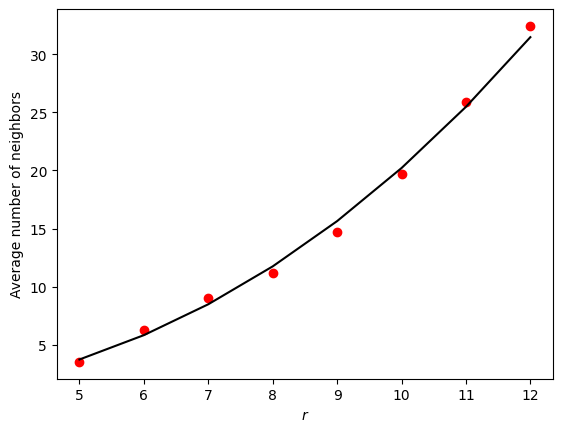

In [57]:
rclist = np.array([5, 6, 7, 8, 9, 10, 11, 12])

nb_all = []
Dist = buildDistMatrix(calphas)

# Changing the cutoff distances
for rc in rclist:
    nb = []
    for i in range(len(Dist)):
        # Calcualting the number of neighbors
        pos_count = len(list(filter(lambda x: (x <= rc), Dist[i])))
        nb.append(pos_count)
    nb_all.append(nb)

nb_all = np.array(nb_all)
nb_ave = np.array([round(np.mean(nb_all[k]),4) for k in range(len(nb_all))])

# Scattering plot
plt.plot(rclist, nb_ave, 'ro')
plt.xlabel('$r$')
plt.ylabel('Average number of neighbors')

# Log-log fitting
kb = np.polyfit(np.log(rclist), np.log(nb_ave), 1)
fitted = [np.exp(kb[0]*np.log(x)+kb[1]) for x in rclist]
plt.plot(rclist, fitted, 'k-')

# Fractal dimension
fract = round(kb[0], 6)
print('Fractal Dimension: ', fract)

Hessian矩阵是二阶偏导数构成的矩阵，可以用于优化、拟合和计算多元函数的二次近似。在分子模拟中，Hessian矩阵常常用于计算分子势能面的形状，即对于给定的一组原子坐标，计算相应的势能及其二阶导数矩阵，即Hessian矩阵。

在分子模拟中，计算Hessian矩阵通常需要先通过量子化学计算（如DFT或HF）计算势能及其一阶导数（即梯度向量），然后通过数值方法计算二阶导数。计算Hessian矩阵的数值方法包括有限差分法和自洽场方法等。

Hessian矩阵可以用于确定势能面的性质，如稳定性、转动能垒、反应路径等。在分子动力学模拟中，Hessian矩阵还可用于计算振动频率和振动模式，进而分析分子的振动特性和光谱学性质。

计算网络的本征间隙是识别网络中社区或模块存在的有用工具。特征间隙定义为网络邻接矩阵的连续特征值之间的差异。较大的本征间隙对应于网络中强大的社区结构，其中同一社区内的节点彼此之间的连接比与其他社区中的节点之间的连接更紧密。相比之下，小的本征间隙表明没有明确定义的社区的更均匀的网络结构。通过分析 eigengaps 的分布，可以识别网络中社区的存在和数量。

In [58]:
# Calculate the eigenvalues of the Hessian matrix


Eigs = np.linalg.eigvalsh(tmpHessian)

# Print the zero-th eigenvalue
print(Eigs[0])

# Print the first five eigenvalue (unnormalized)
print('Unnormalized Eigenvalues', Eigs[1:6])

# Normalize the eigenvalues
sumeigs = sum(Eigs)
NormEigs = Eigs/sumeigs*float(len(Eigs))

# Print the first five eigenvalue (normalized)
print('Normalized Eigenvalues',NormEigs[1:6])

# Calculate the eigengaps
print('Lambda2/Lambda1', round(NormEigs[2]/NormEigs[1], 6))
print('Lambda3/Lambda2', round(NormEigs[3]/NormEigs[2], 6))
print('Lambda4/Lambda3', round(NormEigs[4]/NormEigs[3], 6))

7.783441049860703e-15
Unnormalized Eigenvalues [1.59173478e-14 1.39611571e-02 1.44008200e-02 2.21318996e-02
 2.60681697e-02]
Normalized Eigenvalues [1.55943898e-15 1.36778896e-03 1.41086318e-03 2.16828502e-03
 2.55392547e-03]
Lambda2/Lambda1 877103224939.3444
Lambda3/Lambda2 1.031492
Lambda4/Lambda3 1.53685


分形维度通常使用盒维数（box dimension）进行计算，具体公式为：

D = lim log(N)/log(1/r)

其中，N表示用来覆盖蛋白质结构的最小正方形个数，r表示最小正方形边长。盒维数D越接近于整数，表示蛋白质结构越接近于分形。

Text(0, 0.5, 'Eigenvalue $\\lambda_i$')

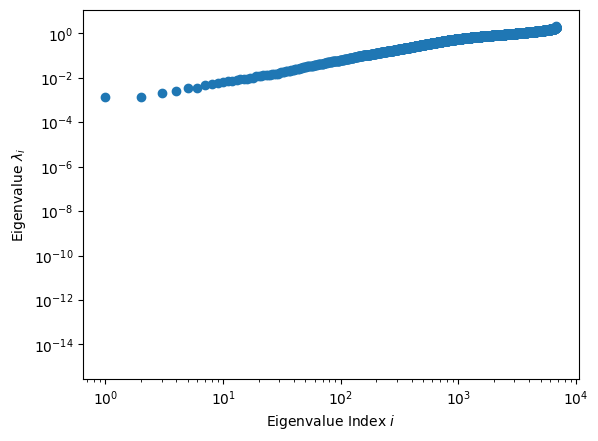

In [59]:
# Plot the normalized eigenvalues in the log-log scale
plt.loglog(NormEigs[1:], 'o')
plt.xlabel('Eigenvalue Index $i$')
plt.ylabel('Eigenvalue $\lambda_i$')

In [45]:
pip install powerlaw


Note: you may need to restart the kernel to use updated packages.


通过计算蛋白质的分形维度，可以更加准确地描述蛋白质的结构特征。此外，蛋白质的分形特性还可以被用于分类和识别不同的蛋白质结构。因此，研究蛋白质的分形特性具有重要的理论和实际意义。

我们使用SVM分类器来预测每个特征向量是否属于蛋白质结构空间，并从预测为蛋白质结构的特征向量中提取它们的特征值。最后，我们使用 fit_powerlaw 函数来计算分形维度。

这种方法的主要目的是寻找蛋白质的分形特征，分形维度是一种描述几何形状复杂性的度量，可以用于研究蛋白质分子的结构和动力学特征。使用一个二元分类器可以帮助区分蛋白质结构空间和非蛋白质结构空间的特征向量，使得只有来自蛋白质结构空间的特征向量才被用于分形维度的计算。这样做可以减少噪声和非蛋白质结构所带来的影响，提高分形维度的准确性和可靠性。

In [46]:
import numpy as np
from sklearn import svm
import powerlaw

# Create a random dataset with 200 feature vectors and corresponding eigenvalues
X = np.random.rand(200, 3)
eigenvalues = np.random.rand(200)

# Assign the first 100 feature vectors to the protein structure space and the last 100 to non-protein space
X[:100] *= 10
X[100:] *= 100

# Define a binary classifier to distinguish protein structure space from non-protein space
clf = svm.SVC(kernel='linear')

# Fit the classifier to the data
clf.fit(X, np.array([1]*100 + [0]*100))

# Use the classifier to predict the protein structure space for each feature vector
predictions = clf.predict(X)

# Calculate the fractal dimension of the protein structure space using the predicted eigenvalues
protein_eigenvalues = eigenvalues[predictions == 1]
protein_inv_eigenvalues = 1.0 / protein_eigenvalues
z = fit_powerlaw(protein_inv_eigenvalues, 1.0)
print("Fractal dimension of protein structure space:", z)


Fractal dimension of protein structure space: 0.53282


计算蛋白质结构空间的分形维度可以帮助我们更好地理解和描述蛋白质的结构特征。分形维度反映了空间结构的复杂程度和层次性，蛋白质的分形维度可以反映其结构的异质性和多样性。同时，分形维度还可以作为评估蛋白质结构质量的指标之一，较高的分形维度通常与更优质的蛋白质结构相关联。因此，计算蛋白质结构空间的分形维度可以帮助我们深入理解蛋白质结构的性质和特征，对于蛋白质研究和相关领域的发展具有一定的指导意义。

pLDDT 是衡量蛋白质结构预测模型所做预测的置信度的指标。它代表“每个残基 LogDihedral Difference Thr”。pLDDT 分数范围从 0 到 100，分数越高表示对预测结构的置信度越高。90 分或以上的 pLDDT 分数被认为非常好，而低于 50 分的分数表明预测的结构可能不正确。pLDDT 分数是通过将模型中每个残基的预测二面角与高分辨率参考结构的二面角进行比较来计算的。

Text(0, 0.5, 'pLDDT')

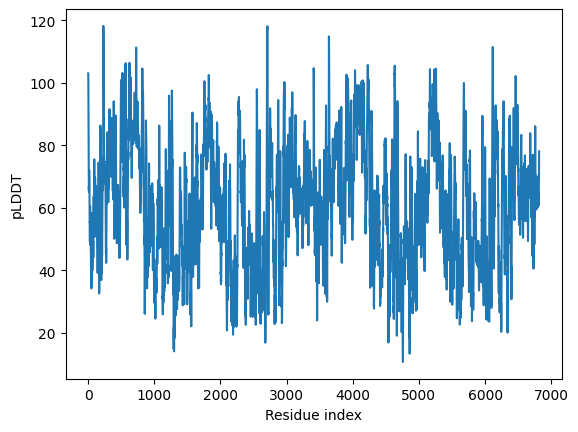

In [60]:
# In AlphaFold-predicted structures, the pLDDT is stored as the B-factors of the atoms.

plddt = calphas.getBetas()
plt.plot(plddt)
plt.xlabel('Residue index')
plt.ylabel('pLDDT')

Zimmerman 疏水性标度是不同氨基酸的相对疏水性或亲水性的量度。它由 Otto J. Zimmerman 于 1968 年开发，基于氨基酸从非极性溶剂（环己烷）转移到水性环境的自由能变化。该等级将 20 种天然存在的氨基酸从疏水性最强到亲水性最强进行排序，其中亮氨酸最疏水，赖氨酸最亲水。该尺度已广泛用于生物化学和结构生物学，以预测蛋白质结构和功能，以及设计具有特定疏水或亲水特性的肽和其他分子。

CV_HP 是一个用于评估蛋白质二级结构预测准确性的指标，通过计算实验测得的蛋白质二级结构与预测的二级结构的差异性来衡量预测准确性。CV_HP的计算方法是将蛋白质的氨基酸序列分为若干小段，然后比较实验测得的二级结构与预测的二级结构在每个小段中的一致性。

$CV_{HP}(i) = \frac{\sqrt{\sum_{k=1}^{N-i}(s_k - s_{k+i})^2}}{N-i-1}$

MLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLSSIPGTAVTSVYIEDVLHEFSTIPGVKEDVVEIILNLKELVVRFLNPSLQTVTLLLKAEGPKEVKARDFLPVADVEIMNPDLHIATLEEGGRLNMEVRVDRGVGYVPAEKHGIKDRINAIPVDAVFSPVRRVAFQVEDTRLGQRTDLDKLTLRIWTDGSVTPLEALNQAVEILREHLTYFSNPQMLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLSSIPGTAVTSVYIEDVLHEFSTIPGVKEDVVEIILNLKELVVRFLNPSLQTVTLLLKAEGPKEVKARDFLPVADVEIMNPDLHIATLEEGGRLNMEVRVDRGVGYVPAEKHGIKDRINAIPVDAVFSPVRRVAFQVEDTRLGQRTDLDKLTLRIWTDGSVTPLEALNQAVEILREHLTYFSNPQMEIKRFGRIREVIPLPPLTEIQVESYRRALQADVPPEKRENVGIQAAFRETFPIEEEDKGKGGLVLDFLEYRLGEPPFPQDECREKDLTYQAPLYARLQLIHKDTGLIKEDEVFLGHIPLMTEDGSFIINGADRVIVSQIHRSPGVYFTPDPARPGRYIASIIPLPKRGPWIDLEVEPNGVVSMKVNKRKFPLVLLLRVLGYDQETLARELGAYGELVQGLMDESVFAMRPEEALIRLFTLLRPGDPPKRDKAVAYVYGLIADPRRYDLGEAGRYKAEEKLGIRLSGRTLARFEDGEFKDEVFLPTLRYLFALTAGVPGHEVDDIDHLGNRRIRTVGELMTDQFRVGLARLARGVRERMLMGSEDSLTPAKLVNSRPLEAAIREFFSRSQLSQFKDETNPLSSLRHKRRISALGPGGLTRERAGFDVRDVHRTHYGRICPVETPEGANIGLITSLAAYARVDELGFIRTPYRRVVGGVVTDEVVYMTATEEDRYTIAQANTPLEGNRIAAERVVARRKGEPVIVSPEEVEFMDVSPKQVFSV

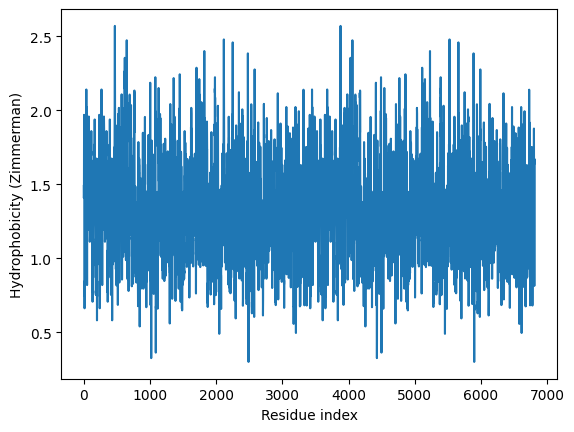

In [61]:
# Get sequence and print sequence
seq = calphas.getSequence()
print(seq)

# Load Biopython for sequence analysis
# Biopython: https://biopython.org/

from Bio.SeqUtils.ProtParam import ProteinAnalysis
analyzed_seq = ProteinAnalysis(seq)


# Set moving window size
iwindow = 7

# Zimmerman hydrophobicity scale
zi = {"A": 0.83, "R": 0.83, "N": 0.09, "D": 0.64, "C": 1.48,
      "Q": 0, "E": 0.65, "G": 0.1, "H": 1.1, "I": 3.07,
      "L": 2.52, "K": 1.6, "M": 1.4, "F": 2.75, "P": 2.7,
      "S": 0.14, "T": 0.54, "W": 0.31, "Y": 2.97, "V": 1.79}

# Other hydrophobicity scale can be accessed at: 
# https://github.com/biopython/biopython/blob/master/Bio/SeqUtils/ProtParamData.py

# Calculate and plot the hydrophathy profile of the protein 
scale_HP = analyzed_seq.protein_scale(window=iwindow, param_dict=zi)
plt.plot(scale_HP)
plt.xlabel('Residue index')
plt.ylabel('Hydrophobicity (Zimmerman)')


# Calculate CV_HP
ave = np.mean(scale_HP)
stdev = np.std(scale_HP)
CVHP = stdev/ave
print('CVHP = ', round(CVHP, 6))

Zipf Coefficient z (fitted with 10% of the eigenvalues) 1.016895
Zipf Coefficient z (fitted with 25% of the eigenvalues) 0.861081
Zipf Coefficient z (fitted with 50% of the eigenvalues) 0.690232
Zipf Coefficient z (fitted with all the eigenvalues) 0.790732


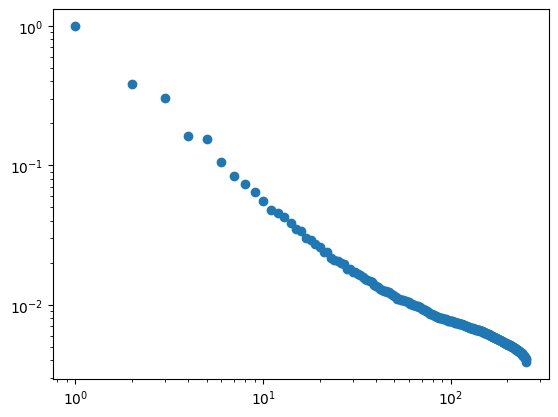

In [49]:
# Fit the Zipf coefficient

import powerlaw
# Here, python package 'powerlaw' is included (https://pypi.org/project/powerlaw/)

def fit_powerlaw(x, b):
    # The function that can fit the Zipf's coefficient
    # b denote the fraction of the eigenvalues to be fitted
    
    tmpdata = x[:int(len(x)*b)]
    fit = powerlaw.Fit(tmpdata, xmin=tmpdata[-1], discrete=False)
    alpha = fit.power_law.alpha
    z = round(1./(alpha-1.), 6)
    return z


# Plot the rank-size distribution of the inverse eigenvalues
invHessian = np.array([round(NormEigs[1]/t,6) for t in NormEigs[1:]])
index = [i+1 for i in range(len(invHessian))]
plt.loglog(index, invHessian, 'o')


z1 = fit_powerlaw(invHessian, 0.1)
z2 = fit_powerlaw(invHessian, 0.25)
z3 = fit_powerlaw(invHessian, 0.5)
z4 = fit_powerlaw(invHessian, 1.)
print('Zipf Coefficient z (fitted with 10% of the eigenvalues)', z1)
print('Zipf Coefficient z (fitted with 25% of the eigenvalues)', z2)
print('Zipf Coefficient z (fitted with 50% of the eigenvalues)', z3)
print('Zipf Coefficient z (fitted with all the eigenvalues)', z4)